# Spectral vs Segmentation? A comparison of two different approaches to classifying lawn area
https://github.com/robbieheumann/Turfgrass2024

# Introduction

Urban areas represent ~ 5% of the total US land area (NRCS, 2024) and can serve as large sources and sinks of nutrients in different areas (e.g. McPhillips et al. 2016; Van Delden et al. 2016). A major component of urban areas are turf grass monocultures (i.e. lawns). Research on biogeochemcial cycling in turf grasses over the last two decades has been slowly increasing, however some hurdles to large scale research on turf grass biogeochemistry still exist. One major hurdle is the the spatial extent of lawn area in the US (Milesi et al. 2005). There is simply a lack of robust spatial datasets at large scales that indentify lawn area. Only one study so far has used a combination of remotely sensed datasets and grouth truth measurements of lawn area to general nationwide estimate of lawn area and nutrient fluxes in and out of these lands (Milesi et al. 2005). Yet more versatile, and accessible tools for identifying and quantifying lawn area would help land managers and ecosystem ecologists bettter understand the spatial extent of this increasing important land cover type. 

For my final project I build off of my midterm project (Tutorial on using object-based image analysis) and compare two different approaches to classifying lawn area in 2021 NAIP imagery of Missoula's University District. My ultimate goal was to be able to develop a model that accurately classifies turf grass and measures turf grass area in a given urban/suburban satellite image. The primary question I sought to answer was: _To what degree are image segmentation based machine learning algorithms accurate tools for identifying and quantifying turf grass areas from satellite images relative to spectal data based algorithms?_). 




# Hypotheses 
I hypothesized that using image segmentation algorithims will add additional spatial information regarding pixel cluster dimensions and patterns that will ultimately improve the classification algorithims ability to predict areas of lawn.

# Technical Approach
My appraoch to this model comparison project can be described in the the five steps below. I worked through these steps following the best practices outlined in Wilson et al. (2014), with particular focus on making my coding style and formatting consistent, with meaningful and dinstinctive naming of program objects while also automating certain parts of this workflow where possible. 

1. Download area of interest imagery and subset training images of lawn area out for model fitting.
2. Calculate NDVI of training images to indentify areas of lawn using just a single value (NDVI value). This just makes it easier for me to mask out lawn vs. non-lawn area.
3. Create a lawn mask using the NDVI pixel values to classify pixel values as 1 (for lawn) or 0 (non-lawn) to fit my model to.
4. Fit a random forest classification model using the spectral band data as input parameters for the model. Then using the same lawn mask image, segment my image into pixel clusters using scikit's 'quickshift' function. Then fit another random forest classification model using the pixel segments as parameters in the model.
5. This will produce two classification models, one using just spectral band data, and the other, using the pixel segmentation data. I will compare the accuracy of these two models using confusion matrices to calculate the percent of pixels wrongly predicted by the two models (false positives and false negatives) 

# 1. Download imagery and subset training images of lawn area.
Here I load the NAIP imagery and import necessary packages for analysis. Luckily for me there is just one image that I work with for this project, making the data required for running this script easy to obtain. The tif image is included in the data folder contained in the same zip folder that houses this notebook. I have the number of bands, projection and geotransform print out here upon downloading the data so that other users of this script can see the basic information associated with this data. The image is from the year 2021, but I still have not yet managed to find information on when exactly during 2021 the image was taken. However as you will see in the image, much of the non-irrigated vegetation (i.e. eastern hillside grass) is dead indicating sometime during the late summer/fall.

In [5]:
from osgeo import gdal
from matplotlib import pyplot
import numpy as np
import scipy as sp
from skimage.segmentation import quickshift
from matplotlib import colors
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from matplotlib import colors
from sklearn.metrics import confusion_matrix

ds = gdal.Open(r'data\missoula_aoi_03_2024.tif', gdal.GA_ReadOnly)
geo_transform = ds.GetGeoTransform()
proj = ds.GetProjectionRef()
bands = ds.RasterCount 
print('Bands =',  bands, 
      "           Projection =", proj, 
      "           Geo Transform =", geo_transform) 

Bands = 5            Projection = PROJCS["NAD83 / UTM zone 12N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-111],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26912"]]            Geo Transform = (271495.9702, 0.6000000000000173, 0.0, 5194695.6, 0.0, -0.5999999999998327)


Below I read my image as an array, so that I can resturcture the pixel coordinates and band values so that the image is able to be plotted in pyplot. 

In [2]:
data = ds.ReadAsArray()
band_data = data[0:4, :, :] ## only retain the first 4 bands (red, green, blue and NIR), not sure what the fifth band is. 
rgb_img = np.rollaxis(band_data, 0, 3)
rgb_img.shape ## check the shape, should be (3339, 2698, 4)

(3339, 2698, 4)

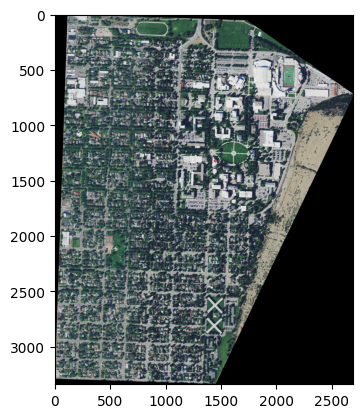

In [3]:
pyplot.imshow(rgb_img[:,:,0:3]) ## Plot the image removing the NIR band just for clarity of image, including the NIR band greys the image heavily. 

###  Subsetting lawn images 
Here I zoom in to different area of the Missoula image to place I know to be grass. Two of the close up images below are of large expanses of grass that I am familiar with, and the third is of a more condensed, tree-covered area I am familiar with. I thought including the more dense, tree covered image would be useful to include in the model so the model learns to distinguish (roughly) between tree vegetation and lawn grass. 

In [4]:
# My three close-up subsetted images plus one test image for later model testing
train1 = rgb_img[200:500, 500:1000, :]
train2 = rgb_img[2500:2800, 1200:1700, :]
train3 = rgb_img[1100:1400, 1300:1800, :]
test = rgb_img[200:500, 800:2300, :]

Text(0.5, 1.0, 'training dataset 3')

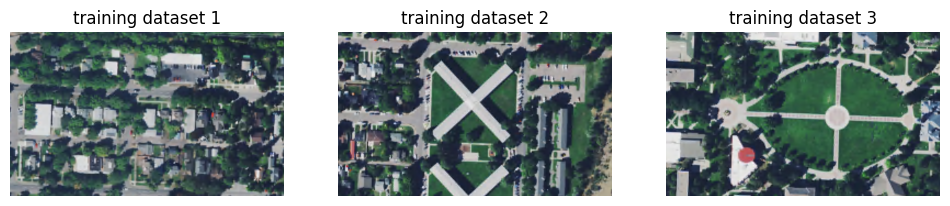

In [5]:
fig, axes = pyplot.subplots(1, 3, figsize=(12, 6))
axes[0].imshow(train1[:, :, 0:3])
axes[0].axis('off')
axes[0].set_title('training dataset 1')
axes[1].imshow(train2[:, :, 0:3])
axes[1].axis('off')
axes[1].set_title('training dataset 2')
axes[2].imshow(train3[:, :, 0:3])
axes[2].axis('off')
axes[2].set_title('training dataset 3')

### Combine images to form one smaller training dataset
Here I simply concatenate the three images to form a single training imag for me to work with. 


In [6]:
train = np.concatenate([train1, train2, train3], axis=1)

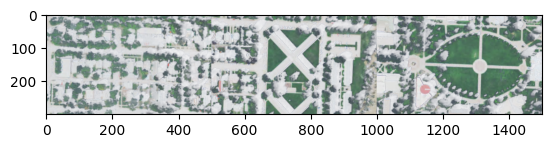

In [7]:
pyplot.imshow(train)

# 2. Calculate NDVI of trianing images to indentify areas of lawn using just a single value (NDVI value).
I learned that it was easier for me to use NDVI calculations (see below) to identify lawn area based on a single pixel NDVI value, instead of identifying combinations of red, green, blue and near-infrared band value combinations that correspond to lawn. This is ultimately what the model is for. So here I first calculate NDVI for each pixel in my training dataset. I then identify a NDVI value threshold that I believe accurately represents just lawn grass and use that to mask out lawn area. 

C:\Users\rh176228\AppData\Local\Temp\ipykernel_23320\2261273815.py:1: RuntimeWarning: divide by zero encountered in divide
  train_ndvi = ((train[:, :, 3]) - (train[:, :, 0]) / (train[:, :, 3] + train[:, :, 0]))


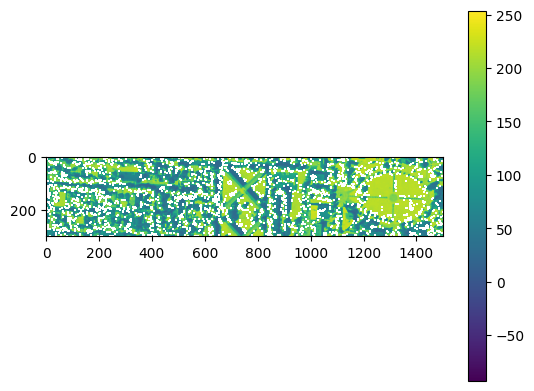

In [8]:
train_ndvi = ((train[:, :, 3]) - (train[:, :, 0]) / (train[:, :, 3] + train[:, :, 0]))
pyplot.imshow(train_ndvi)
pyplot.colorbar()

# 3. Create a lawn mask using the NDVI pixel values 
After manually experimenting with NDVI value thresholds that roughly match what I know as lawns in the training image, I decided on an NDVI value of 190 as a good threshold to create my lawn mask. 

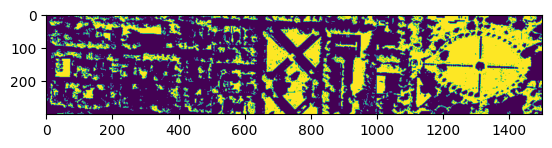

In [9]:
pyplot.imshow(train_ndvi>=190)

### Identifying the lawn pxiels
Below I'm creating a mask of pxiels that meet my threshold criteria, setting the rest of the pixels that don't to zero. I then create create a list of the pixel coordinates from my mask that are grass, based on the NDVI value (this is called `pixel_coordinates`). I then store those extracted pixels in `extracted_pixels` using a `for` loop to iteratively select the pixel coordinates that contain pixels with lawn NDVI values in them from the original `train` dataset. This allows me to obtain the spectral band data for my lawn pixels. That image (`extracted_pixels`) is then plotted below. 

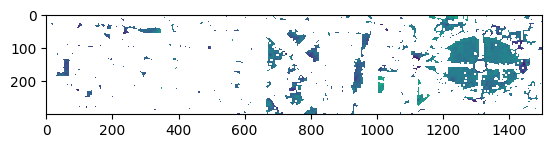

In [10]:
training_grass = np.ma.masked_where(train_ndvi < 190, train_ndvi)
pyplot.imshow(training_grass)

In [11]:
grass_indices = np.where(training_grass > 190)

# Zip the indices to get the pixel coordinates
pixel_coordinates = list(zip(grass_indices[0], grass_indices[1]))

# Initialize an empty array to store the extracted pixels
extracted_pixels = np.zeros_like(train)

# Loop through each pixel coordinate and extract the corresponding pixel value
for coord in pixel_coordinates:
    row, col = coord
    extracted_pixels[row, col] = train[row, col]

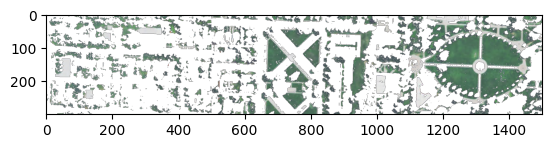

In [12]:
pyplot.imshow(extracted_pixels)

# 4 - Spectral model. Fit a random forest classification model using the spectral band data as input parameters for the model
I now have to restucture my extracted pixels data frame so that all the band data values for each pixel are stored in a 2-dimensional array in order to fit my model. So I first define a function to extract the pixel values from each band then store them in a 2-dimensional array. I include a couple different lines of code to make sure there are no NAs in the data, and then to make sure that all the pixel values are either 1 (lawn) or 0 (non-lawn). I end up using the max band value for grass pixels in my extracted pixel image to obtain a 2-dimensional image with values of pixels greater than 0 corresponding to lawn area and the rest non lawn. This only serves as $y$ outcome variable to fit my model to. 

In [13]:
np.argwhere(np.isnan(extracted_pixels)) ## any NAs? should result in an array with no array values ([]) meaning there are no NAs

array([], shape=(0, 3), dtype=int64)

In [14]:
flat_grass = np.max(extracted_pixels, axis=2) # max band value to obtain a 2-dimensional image that can be easily classified to 1 or 0
flat_grass.shape

(300, 1500)

In [15]:
extracted_pixels.shape

(300, 1500, 4)

### Make sure that there are only values of 1 or 0 in the processed data frame. This will serve as the y parameter in the model, so it must only be a 2 dimensional binary map. 

In [16]:
flat_grass_processed = (flat_grass > 0).astype(int)

In [17]:
valid_values = np.all(np.logical_or(flat_grass_processed == 0, flat_grass_processed == 1))

all_valid = np.all(valid_values)

if all_valid:
    print("All pixel values are either 0 or 1.")
else:
    print("Pixel values other than 0 or 1 are present.")

All pixel values are either 0 or 1.


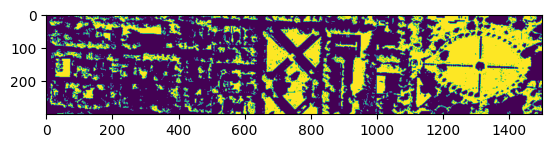

In [18]:
pyplot.imshow(flat_grass_processed)

## Extracting individual band data
Below I sum the band data ( > 0 assuming non-lawn areas have been masked out already) from `extracted_pixels` to obtain a 2 dimensional array that integrates all the band values for each pixel into one value (the sum). 

In [19]:
x_band_sum = np.sum(extracted_pixels, axis = 2)
x_band_sum.shape

(300, 1500)

### Fit random forest
Below I fit the random forest model to my 2-dimension band sum values with the processed 2-dimension binary lawn area image `flat_grass_processed` data as my y. I chose a minimum of 2 samples per leaf based on previous values we have used in this class, and to speed up the model fitting process. However this parameterization can be experimented with if I more complex model fit is desired. 

In [20]:
model = RandomForestClassifier(min_samples_leaf = 2)
model.fit(x_band_sum, flat_grass_processed)

RandomForestClassifier(min_samples_leaf=2)

### Assess model accuracy
Below I first create an array of my model predictions, then define a function that flattens the prediction and true lawn value arrays into 1 dimensional arrays. A confusion matrix is then calculated within the function. The plotted matrix is shown below. 

In [21]:
y_pred = model.predict(x_band_sum)

In [22]:
def cf_preprocess(y_pred, flat_grass_processed):
    y_pred_cf = y_pred.flatten()
    flat_grass_cf = flat_grass_processed.flatten() 
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(flat_grass_cf, y_pred_cf)

    return conf_matrix 


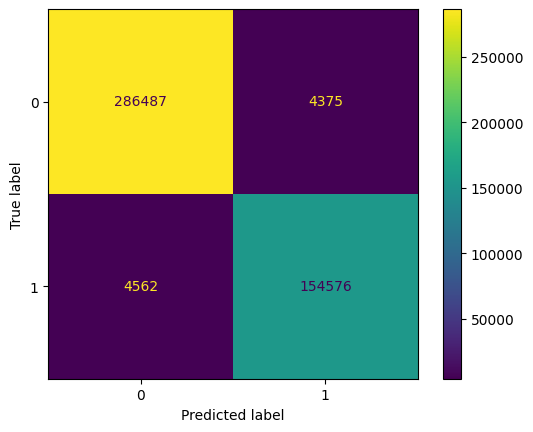

In [23]:
spectral_cf = cf_preprocess(y_pred, flat_grass_processed)
spectral_cf_plot = ConfusionMatrixDisplay(confusion_matrix = spectral_cf)
spectral_cf_plot.plot()

### Calculate basic model accuracy statistic :   $\frac{(\text{false positives} + \text{false negatives})}{\text{total number of pixels}}$  

*** NOTE: this nuber will change slightly with every run - need to check the false positive and false negative numbers after every run

In [24]:
(4531+4298)/np.prod(y_pred.shape)*100

1.9619999999999997

### As you can see, this model performed relatively well internally (predicting using the training data) with a 1.96 misclassification rate. However, how will it perform on data it has not been trained on?

C:\Users\rh176228\AppData\Local\Temp\ipykernel_23320\2795262143.py:1: RuntimeWarning: divide by zero encountered in divide
  test_ndvi = ((test[:, :, 3]) - (test[:, :, 0]) / (test[:, :, 3] + test[:, :, 0]))
C:\Users\rh176228\AppData\Local\Temp\ipykernel_23320\2795262143.py:1: RuntimeWarning: invalid value encountered in divide
  test_ndvi = ((test[:, :, 3]) - (test[:, :, 0]) / (test[:, :, 3] + test[:, :, 0]))


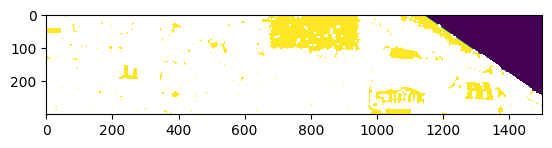

In [25]:
test_ndvi = ((test[:, :, 3]) - (test[:, :, 0]) / (test[:, :, 3] + test[:, :, 0]))
test_grass = np.ma.masked_where(test_ndvi < 190, test_ndvi)

## using same process as earlier to extract lawn pixels to identify true lawn areas for testing
test_grass_processed = (test_grass > 0).astype(int)
pyplot.imshow(test_grass_processed)

In [26]:
test_band_sum = np.sum(test, axis = 2)
test_band_sum.shape

(300, 1500)

## Test model on new image of Missoula University district

In [27]:
test_pred = model.predict(test_band_sum)

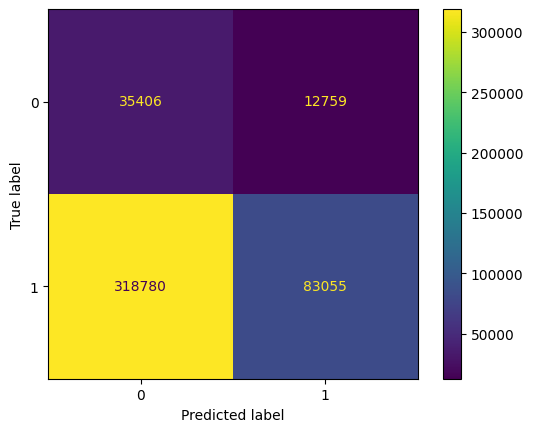

In [49]:
def cf_preprocess_t(test_pred, test_grass_processed):
    test_pred_cf = test_pred.flatten()
    test_grass_processed_cf = test_grass_processed.flatten() 
    
    # Compute the confusion matrix
    conf_matrix_t = confusion_matrix(test_grass_processed_cf, test_pred_cf)

    return conf_matrix_t

spectral_cf_t = cf_preprocess_t(test_pred, test_grass_processed) 
spectral_cft_plot = ConfusionMatrixDisplay(confusion_matrix = spectral_cf_t)
spectral_cft_plot.plot()

In [29]:
(318856+12208)/np.prod(test_pred.shape)*100

73.56977777777777

### As you can see, this model performed much worse on imagery it was not trained on, with a misclassification rate of 73.56% shown above. 

# 4 - Segmentation based model. Using the same lawn mask image, segment my image into pixel clusters using scikit's 'quickshift' function. Then fit another random forest classification model using the pixel segments as parameters in the model. 
Below, I first run the quickshift function on my `train` array setting `kernel_size` to 4, `max_dist` to 4 and `ratio` to 0.75. I found these values helped increase  pixel cluster size and speed up the amount of time it takes for the segmentation process to finish. However these can be adjusted if higher resolution segements are desired. 

In [30]:
grass_segs = quickshift(train, kernel_size=4, max_dist=4, ratio=0.75, convert2lab=False)
n_segments = len(np.unique(grass_segs))
print(n_segments) ## number of segments produced

1598


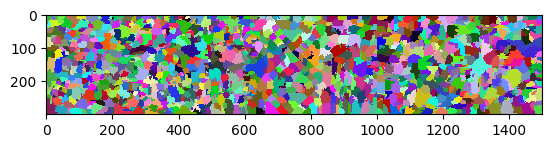

In [31]:
cmap = colors.ListedColormap(np.random.rand(n_segments, 3))  
## Here I am just plotting the segmented image giving eachs segment a unqiue color to visualize the segmentation patterns
pyplot.imshow(grass_segs, interpolation='none', cmap=cmap)

In [32]:
segments_extract_grass = np.zeros_like(grass_segs)

# Loop through each pixel coordinate and extract the corresponding pixel value, this creates a segments training array
for coord in pixel_coordinates:
    row, col = coord
    segments_extract_grass[row, col] = grass_segs[row, col]

segments_extract_grass.shape

(300, 1500)

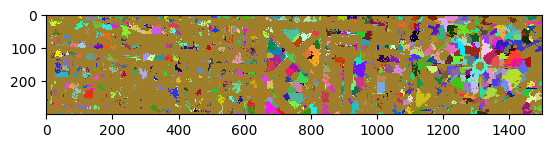

In [33]:
pyplot.imshow(segments_extract_grass, interpolation='none', cmap=cmap) ## this is what the segment training dataset looks like

### Fit the classification model to the grass segments training array `grass segs` with the original true lawn area image `flat_grass_processed` as y.

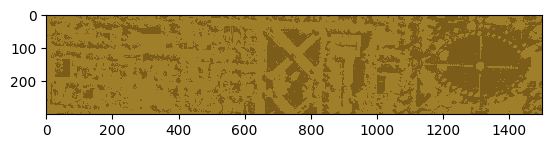

In [34]:
pyplot.imshow(flat_grass_processed, interpolation='none', cmap=cmap)

In [35]:
segments_mod = model.fit(grass_segs, flat_grass_processed)

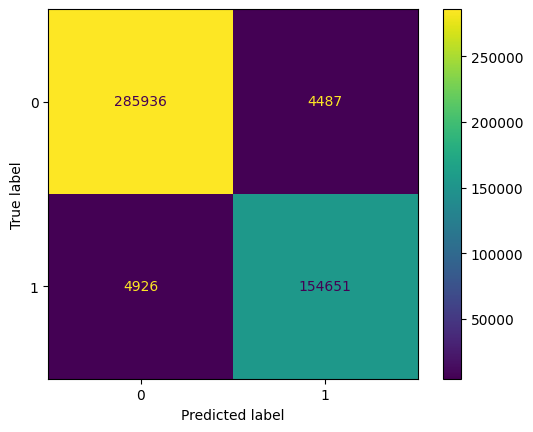

In [36]:
predictions_segs = segments_mod.predict(grass_segs)
predictions_segs_cf = predictions_segs.flatten()
flat_grass_cf = flat_grass_processed.flatten() 
segs_cf = confusion_matrix(predictions_segs_cf, flat_grass_cf)
segs_cf_plot = ConfusionMatrixDisplay(confusion_matrix = segs_cf)
segs_cf_plot.plot()

### Assess model accuracy (internal) 

In [37]:
(4930+4474)/np.prod(predictions_segs.shape)*100

2.089777777777778

### As you can see, this model also performs well on the training data with a misclassification rate of 2.08%. However how does it perform on data is has not seen yet?
In order to answer this, I first need to segment my test image

In [38]:
## segmenting test image, same function used before just with test array
test_segs = quickshift(test, kernel_size=4, max_dist=4, ratio=0.75, convert2lab=False)
n_segments_t = len(np.unique(test_segs))
print(n_segments_t)

2119


### Now I can assess the segmentation model accuracy in predicting test lawn areas

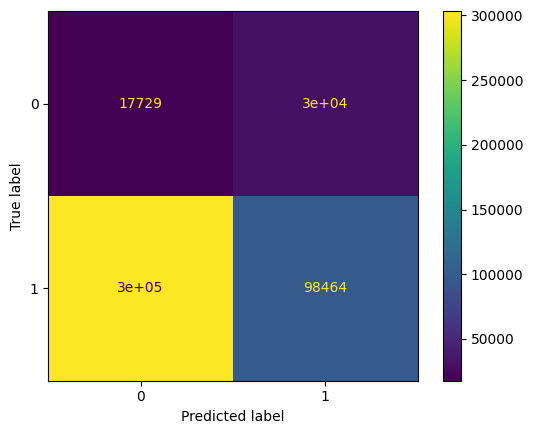

In [39]:
predictions_segs_t = segments_mod.predict(test_segs)
predictions_segs_cft = predictions_segs_t.flatten()
segment_cf_t = cf_preprocess_t(predictions_segs_cft, test_grass_processed) 
segment_cf_t_plot = ConfusionMatrixDisplay(confusion_matrix = segment_cf_t)
segment_cf_t_plot.plot()

In [40]:
(305744+30000)/np.prod(predictions_segs.shape)*100 ## Again note this value will change with every run so adjust misclassification values accordingly
## Ideally, automating this calculation would be best!

74.60977777777778

### As you can see, this model also performed significantly worse on test data it had not seen before with a misclassification rate of 74.61% - slightly higher than the spectral based model. 

# Conclusion: Comparison of the two approaches
In conclusion, the spectral band based classification model slightly outperformed the segmentation based model (73.57% misclassification rate vs 74.61% respectively). However neither of these models prove to be effective tools for classifying lawn area. MY hypothesis was therefore incorrect, although marginally incorrect as spectral based models appear not to be a great alternative. There are a number of reasons why that might be. Here I discuss two reasons I think are particularly likely. While upon reviewing my code several times, I'm relatively confident that my the image masks of lawn and the processed data arrays from those masks which I fit my model too have been correctly programmed. However I am less confident in my application of the quickshift algorithim. While the function documentation states the input image must be given in RGB format, which I did, I'm worried that the algorithim is not correctly recognizing the shape of the grass mask I use to fit the model to initially. In other words, I don't think I'm parameterizing the algorithim well enough despite specifying a ratio value of 0.95 which gives more weight to color space during the segmentation process. Perhaps with better training data (e.g. shapefiles of known lawn/turf grass areas) could better constrain the quickshift function and therefore improve the overall fit of the model to segmented images. Secondly, I do not think my NDVI threshold of 190 used to mask out areas of non-lawn surfaces is extremely accurate. It is likely that this mask still includes some non-lawn vegetation ( e.g. trees) that could explain why the model, in both approaches, struggles to accruately predict lawn surface in external tests. Therefore, approaches that can better distinguish between lawn vegetation and non-lawn vegetation could improve the overall performance of both these modeling approaches. Overall, this modeling approach demonstrates some potential, with better training data and model parameterization to be a useful tool for classifying lawn area, but as is I would not recommend this approach to land managers. 

# References
McPhillips, L.E., Groffman, P.M., Schneider, R.L. and Walter, M.T., 2016. Nutrient cycling in grassed roadside ditches and lawns in a suburban watershed. Journal of Environmental Quality, 45(6), pp.1901-1909.
Milesi, C., Running, S.W., Elvidge, C.D., Dietz, J.B., Tuttle, B.T. and Nemani, R.R., 2005. Mapping and modeling the biogeochemical cycling of turf grasses in the United States. Environmental management, 36, pp.426-438.
NRCS, 2024; https://www.ers.usda.gov/about-ers/partnerships/strengthening-statistics-through-the-icars/land-use-and-land-cover-estimates-for-the-united-states/
Van Delden, L., Rowlings, D.W., Scheer, C. and Grace, P.R., 2016. Urbanisation-related land use change from forest and pasture into turf grass modifies soil nitrogen cycling and increases N 2 O emissions. Biogeosciences, 13(21), pp.6095-6106.
Wilson G, Aruliah DA, Brown CT, Chue Hong NP, Davis M, et al. (2014) Best Practices for Scientific Computing. PLOS Biology 12(1): e1001745. https://doi.org/10.1371/journal.pbio.1001745